In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio


In [2]:
#load initial csv
initial_data = pd.read_csv('Taxi_Trips.csv')

#show columns in initial dataset
print('Columns in initial dataframe')
print(initial_data.columns)

Columns in initial dataframe
Index(['Trip ID', 'Taxi ID', 'Trip Start Timestamp', 'Trip End Timestamp',
       'Trip Seconds', 'Trip Miles', 'Pickup Census Tract',
       'Dropoff Census Tract', 'Pickup Community Area',
       'Dropoff Community Area', 'Fare', 'Tips', 'Tolls', 'Extras',
       'Trip Total', 'Payment Type', 'Company', 'Pickup Centroid Latitude',
       'Pickup Centroid Longitude', 'Pickup Centroid Location',
       'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude',
       'Dropoff Centroid  Location'],
      dtype='object')


In [3]:
#select desired rows
#Trip Start Timestamp, Trip End Timestamp, Trip Seconds, Trip Miles, Fare, Extras
#Company, Pickup Centroid Latitude, Pickup Centroid Longitude, Dropoff Centroid Latitude, Dropoff Centroid Longitude 

cab_fare_df = initial_data.iloc[: ,[2,3,4,5,10,13,16,17,18,20,21]].copy()
print('Columns in new cab fare dataframe')
print(cab_fare_df.columns)
#print(cab_fare_df.dtypes)
initial_rows = len(cab_fare_df)
print(f"Initial length of dataframe: {initial_rows}")

Columns in new cab fare dataframe
Index(['Trip Start Timestamp', 'Trip End Timestamp', 'Trip Seconds',
       'Trip Miles', 'Fare', 'Extras', 'Company', 'Pickup Centroid Latitude',
       'Pickup Centroid Longitude', 'Dropoff Centroid Latitude',
       'Dropoff Centroid Longitude'],
      dtype='object')
Initial length of dataframe: 865247


In [4]:
#drop duplicates
cab_fare_df.drop_duplicates()

print(f"Length of dataframe after dropping duplicates: {len(cab_fare_df)}")

#check null values
print('Null values in columns')
print(cab_fare_df.isnull().sum())


Length of dataframe after dropping duplicates: 865247
Null values in columns
Trip Start Timestamp              0
Trip End Timestamp                8
Trip Seconds                    169
Trip Miles                        6
Fare                           2045
Extras                         2045
Company                           0
Pickup Centroid Latitude      22966
Pickup Centroid Longitude     22966
Dropoff Centroid Latitude     79675
Dropoff Centroid Longitude    79675
dtype: int64


In [5]:
#handle blank latitudes and longitudes by filling in with mean
 
cab_fare_df['Pickup Centroid Latitude'] = cab_fare_df['Pickup Centroid Latitude'].fillna(cab_fare_df['Pickup Centroid Latitude'].mean())

cab_fare_df['Pickup Centroid Longitude'] = cab_fare_df['Pickup Centroid Longitude'].fillna(cab_fare_df['Pickup Centroid Longitude'].mean())
cab_fare_df['Dropoff Centroid Latitude'] = cab_fare_df['Dropoff Centroid Latitude'].fillna(cab_fare_df['Dropoff Centroid Latitude'].mean())
cab_fare_df['Dropoff Centroid Longitude'] = cab_fare_df['Dropoff Centroid Longitude'].fillna(cab_fare_df['Dropoff Centroid Longitude'].mean())


In [6]:
#drop rows with NA values
print('Columns still containing null values')
print(cab_fare_df.isnull().sum())
cab_fare_df = cab_fare_df.dropna()
print(f"Length of dataframe after dropping NAs: {len(cab_fare_df)}")

Columns still containing null values
Trip Start Timestamp             0
Trip End Timestamp               8
Trip Seconds                   169
Trip Miles                       6
Fare                          2045
Extras                        2045
Company                          0
Pickup Centroid Latitude         0
Pickup Centroid Longitude        0
Dropoff Centroid Latitude        0
Dropoff Centroid Longitude       0
dtype: int64
Length of dataframe after dropping NAs: 863104


In [7]:
#Chicago coordinates: 41.8832° N, 87.6324° W
print(cab_fare_df['Pickup Centroid Latitude'].describe())
print(cab_fare_df['Pickup Centroid Longitude'].describe())
print(cab_fare_df['Dropoff Centroid Latitude'].describe())
print(cab_fare_df['Dropoff Centroid Longitude'].describe())
#min and max of all coordinates are appropriate 

count    863104.000000
mean         41.902210
std           0.065553
min          41.660136
25%          41.878866
50%          41.899156
75%          41.979071
max          42.021224
Name: Pickup Centroid Latitude, dtype: float64
count    863104.000000
mean        -87.704675
std           0.113971
min         -87.913625
25%         -87.756047
50%         -87.642808
75%         -87.626211
max         -87.534903
Name: Pickup Centroid Longitude, dtype: float64
count    863104.000000
mean         41.892118
std           0.056696
min          41.650222
25%          41.878866
50%          41.892124
75%          41.914616
max          42.021224
Name: Dropoff Centroid Latitude, dtype: float64
count    863104.000000
mean        -87.659563
std           0.064738
min         -87.913625
25%         -87.663416
50%         -87.642649
75%         -87.626211
max         -87.534903
Name: Dropoff Centroid Longitude, dtype: float64


All of the dropoff and pickup coordinates are in a reasonable range. There is no need to drop any coordinates.

In [ ]:
#view trip seconds, miles, fare, and extras

print(cab_fare_df['Trip Seconds'].describe())
print(cab_fare_df['Trip Miles'].describe())
print(cab_fare_df['Fare'].describe())
print(cab_fare_df['Extras'].describe())
print(f"Current length of dataframe: {len(cab_fare_df)}")

In [8]:
#filter erroneous entries for miles, seconds, fare

cab_fare_df = cab_fare_df[(cab_fare_df['Trip Seconds']>60) & (cab_fare_df['Trip Miles']>0) & (cab_fare_df['Fare']>0)]
print(f"Length of dataframe after removing erroneous entries: {len(cab_fare_df)}")


Length of dataframe after removing erroneous entries: 767314


In [9]:
#filter outliers for seconds and miles 

#define a function to return the low and high thresholds for outliers
def find_outliers(df_column):
    q1 = df_column.quantile(0.25)
    q3 = df_column.quantile(0.75)
    iqr = q3 - q1
    low = float(q1 - (1.5*iqr))
    high = float(q3 + (1.5*iqr))
    return low, high

#define a function to find the percentage of values in a column that are outliers
def find_percent_outliers(df_column):
    low, high = find_outliers(df_column)
    prop_outliers = 1-(df_column.between(low, high).sum()/len(df_column))
    percent_outlier = prop_outliers*100
    return percent_outlier

print(f"Percent of Trip Seconds that are outliers: {round(find_percent_outliers(cab_fare_df['Trip Seconds']),4)}%")
print(f"Percent of Trip Miles that are outliers: {round(find_percent_outliers(cab_fare_df['Trip Miles']),4)}%")

#since %outliers is so low, we can filter out outliers for seconds and miles
s_low, s_high = find_outliers(cab_fare_df['Trip Seconds'])
cab_fare_df = cab_fare_df[cab_fare_df['Trip Seconds'].between(s_low, s_high)]

m_low, m_high = find_outliers(cab_fare_df['Trip Miles'])
cab_fare_df = cab_fare_df[cab_fare_df['Trip Miles'].between(m_low, m_high)]

    

Percent of Trip Seconds that are outliers: 2.3148%
Percent of Trip Miles that are outliers: 0.7134%


In [10]:
#filtering outliers in fare and extras

print(f"Percent of fares that are outliers: {round(find_percent_outliers(cab_fare_df['Fare']),4)}%")
print(f"Percent of extra charges that are outliers: {round(find_percent_outliers(cab_fare_df['Extras']),4)}%")

#drop these outliers
f_low, f_high = find_outliers(cab_fare_df['Fare'])
cab_fare_df = cab_fare_df[cab_fare_df['Fare'].between(f_low, f_high)]

x_low, x_high = find_outliers(cab_fare_df['Extras'])
cab_fare_df = cab_fare_df[cab_fare_df['Extras'].between(x_low, x_high)]

print(f"Length of dataframe after filtering outliers: {len(cab_fare_df)}")


Percent of fares that are outliers: 0.2431%
Percent of extra charges that are outliers: 2.7744%
Length of dataframe after filtering outliers: 723010


In [ ]:
#calculating % dropped
cleaned_rows = len(cab_fare_df)
dropped_rows = initial_rows - cleaned_rows
percent_dropped = round(dropped_rows/initial_rows,4)*100
print(f"Initial number of rows: {initial_rows}")
print(f"Final number of rows after cleaning: {cleaned_rows}")
print(f"Percent of dataset dropped: {percent_dropped}%")

In [11]:
#sum fare and extras columns 
cab_fare_df['Trip Cost'] = cab_fare_df['Fare'] + cab_fare_df['Extras']

In [46]:
#convert pickup timestamp column

cab_fare_df['Trip Start Timestamp'] = pd.to_datetime(cab_fare_df['Trip Start Timestamp'], format="%m/%d/%Y %I:%M:%S %p")
#cab_fare_df['Trip End Timestamp'] = pd.to_datetime(cab_fare_df['Trip End Timestamp'])

#create month column 
cab_fare_df['Month'] = cab_fare_df['Trip Start Timestamp'].dt.month
#print(cab_fare_df['Month'].unique())

#create hour column
cab_fare_df['Hour'] = cab_fare_df['Trip Start Timestamp'].dt.hour 
print(cab_fare_df['Hour'].unique())


[ 0 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1]


This dataset only contains rides from January-March 2024. The month column, therefore, will not be useful for analysis since not all the months are represented.

In [29]:
#bin times into am/pm

cab_fare_df['am or pm'] = np.where(cab_fare_df['Hour']>=12, 'pm', 'am').astype(str)

In [30]:
print(cab_fare_df.dtypes)

Trip Start Timestamp          datetime64[ns]
Trip End Timestamp                    object
Trip Seconds                         float64
Trip Miles                           float64
Fare                                 float64
Extras                               float64
Company                               object
Pickup Centroid Latitude             float64
Pickup Centroid Longitude            float64
Dropoff Centroid Latitude            float64
Dropoff Centroid Longitude           float64
Trip Cost                            float64
Month                                  int32
Hour                                   int32
am or pm                              object
dtype: object


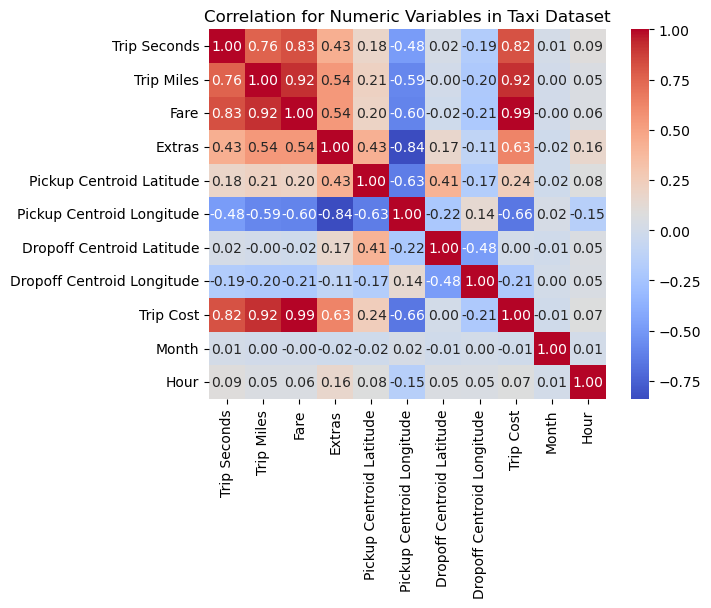

In [47]:
#correlation matrix for numeric variables
correlation = cab_fare_df.corr(numeric_only=True)
#print(correlation)

#heatmap of correlation matrix
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation for Numeric Variables in Taxi Dataset')
plt.show()

Looking at the correlation matrix heatmap, the variables most highly associated with the dependent variable, trip cost, are seconds, miles, pickup longitude. Fare and extras are associated with cost because those were the two variables summed to calculate cost. 

There are very weak associations between trip cost and the pickup month and hour. There is no observed association between cost and dropoff latitude. 

In [ ]:
#view all taxi companies

all_companies = cab_fare_df['Company'].unique()
print(all_companies, len(all_companies))

In [13]:
#target encoding

#sample ~20% of dataframe
target_sample = cab_fare_df.sample(n=150000, random_state=456)

target_mean = target_sample.groupby('Company')['Trip Cost'].mean()
target_sample['Company_mean'] = target_sample['Company'].map(target_mean)

company_correlation = target_sample['Company_mean'].corr(target_sample['Trip Cost'])
print(f"The correlation between taxi company and trip cost is {company_correlation}")

The correlation between taxi company and trip cost is 0.12948723294757755


After target encoding, the correlation between company and cost was only 0.129, which is not very high. Therefore, I feel comfortable not including company as a variable in any further analysis. 

## Exploratory Data Analysis

In [49]:
#creating sample dataframe for EDA

sample = cab_fare_df.sample(n=50000, random_state=123)
avg_cost = sample['Trip Cost'].mean()
print('Average cost =', avg_cost)

Average cost = 22.290428800000004


In [ ]:
#boxplots of seconds and miles features
 
fig = make_subplots(rows=1, cols=2, subplot_titles=("Seconds", "Miles"))

# seconds plot
fig.add_trace(
    go.Box(y = sample['Trip Seconds'], name="Seconds"), row=1, col=1)

# miles
fig.add_trace(
    go.Box(y = sample['Trip Miles'], name="Miles"), row=1, col=2)

fig.update_layout(width=800, height=400, title="Plots of Seconds and Miles") 
fig.show()


The boxplot of trip time in seconds shows that the median time for trips is 935 seconds, or almost 16 minutes. With the exception of outliers, the longest trip in second is 3159, or almost 53 minutes. 

The median number of miles for a trip is 3.8 with the majority of trips being less than 28 miles. 

In [ ]:
#histograms of fares, extra charges, and total cost

dist = make_subplots(rows=3, cols=1, subplot_titles=("Fare", "Extras", "Total Cost"))

dist.add_trace(
    go.Histogram(x=sample["Fare"], name="Distribution of Cab Fares", histnorm="percent",
                xbins=dict(start=0, end=70, size=5)), row=1, col=1)

dist.add_trace(
    go.Histogram(x=sample["Extras"], name="Distribution of Extra Charges", histnorm="percent",
                xbins=dict(start=0, end=10, size=1)), row=2, col=1)

dist.add_trace(
    go.Histogram(x=sample["Trip Cost"], name="Distribution of Total Costs", histnorm="percent",
                xbins=dict(start=0, end=80, size=5)), row=3, col=1)

dist.update_layout(width=1000, height=800, title="Distributions of Fares, Extras, and Totals") 
dist.update_yaxes(title_text="Percentage", row=1, col=1)
dist.update_yaxes(title_text="Percentage", row=1, col=2)
dist.update_yaxes(title_text="Percentage", row=1, col=3)

dist.update_xaxes(title_text="Fare in USD", row=1, col=1)
dist.update_xaxes(title_text="Extra Charges in USD", row=1, col=2)
dist.update_xaxes(title_text="Total Cost in USD", row=1, col=3)

dist.show()


The distributions of fare and total cost line up almost perfectly. This makes sense as total cost is the sum of fare and extras, and most extra charges fall between zero and one dollar. So cost is going to be more determined by fare than by extra charges. 

In [ ]:
#scatterplots of miles v cost

m_plot = px.scatter(sample, x=sample['Trip Miles'], y=sample['Trip Cost'], trendline='ols', trendline_color_override = 'black',
                    render_mode="webgl")
m_plot.update_layout(title='Trip Miles vs Trip Cost in USD')
m_plot.show()

This plot shows that there is a positive trend between the lengths of trips and their costs; as the number of miles increases, the cost of the trip also increases. There are also a few vertical outliers closer to the lower end of the number of miles. These shorter trips are more expensive than trips of a similar distance tend to be. This could be due to extra charges or traffic increasing the duration of trip time without increasing the mileage. 

In [ ]:
#scatterplot of seconds v cost

s_plot = px.scatter(sample, x=sample['Trip Seconds'], y=sample['Trip Cost'], trendline='ols', trendline_color_override = 'black',
                    render_mode="webgl")
s_plot.update_layout(title='Trip Seconds vs Trip Cost in USD')
s_plot.update_traces(marker=dict(color='green'))
s_plot.show()

This plot also shows a positive trend between trip cost and trip time in seconds. There is more scatter in this plot than in the plot of miles. There tends to be a wider range of costs associated with any given trip duration in seconds. 

In [ ]:
#pickup density heatmap 

hb = plt.hexbin(sample['Pickup Centroid Longitude'], sample['Pickup Centroid Latitude'], gridsize=50, cmap='viridis')
plt.close()

verts = hb.get_offsets()
counts = hb.get_array()

fig = go.Figure(go.Scatter(x=verts[:,0], y=verts[:,1], mode='markers', marker=dict(size=10, color=np.log1p(counts),
        colorscale='Viridis', showscale=True, colorbar=dict(title="Log of Pickup Counts per Location"))))

fig.update_layout(width=1000, height=800, xaxis_title='Longitude', yaxis_title='Latitude', title='Pickup Density')
fig.show()

This pickup density grid shows that there are a few locations with higher ratios of pickups. The majority of the latitude/longitude pairs were tracking lower numbers of pickup orders. So much so, that I decided to use the log of the counts to show a little more distinction in pickup density. 

In [ ]:
#heatmap of average duration of trip across different hours and distances

miles = np.linspace(sample['Trip Miles'].min(), sample['Trip Miles'].max(), 28)
sample['Miles_bin'] = pd.cut(sample['Trip Miles'], bins=miles)
sample['Miles_bin_center'] = sample['Miles_bin'].apply(lambda x: x.mid)


agg = sample.groupby(['Hour', 'Miles_bin_center'],observed=True)['Trip Seconds'].mean().reset_index(name='Avg_Seconds')

pivot = agg.pivot(index='Hour', columns='Miles_bin_center', values='Avg_Seconds')
t_heatmap = go.Figure(go.Heatmap(z=pivot.values, x=pivot.columns, y=pivot.index, colorscale='Viridis',
    colorbar=dict(title='Avg Trip Seconds')))

t_heatmap.update_layout(title='Average Trip Seconds by Trip Miles and Hour of Day', xaxis_title='Trip Miles',
    yaxis_title='Hour of Day', width=1000, height=600)

t_heatmap.show()

This heatmap illustrates the relationship between hour of day, distance of trip, and trip duration in seconds. It depicts logical conclusions like that shorter trips take less time than longer ones, regardless of time of day. Also, trips over 20 miles are rarer, especially in the early mornings. One noteworthy observation is that for trips between 15 and 20 miles, the average time it takes seems to increase from around 7-8am and again from around 3-6pm. This likely corresponds to an increase in morning and evening rush hour traffic. 

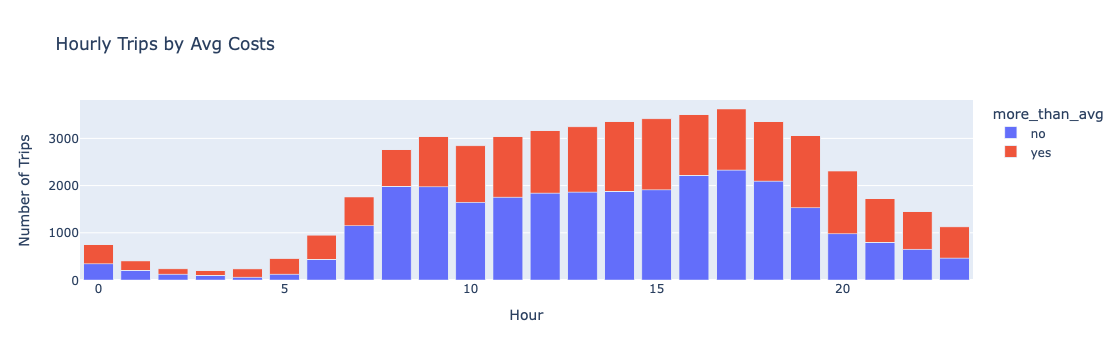

In [53]:
#stacked bar of hour vs avg cost

#bin cost
sample['more_than_avg'] = np.where(sample['Trip Cost']>avg_cost, 'yes', 'no')

grouped = (sample.groupby(['Hour', 'more_than_avg'], observed=True).size().reset_index(name='Number of Trips'))

bar = px.bar(grouped, x='Hour', y='Number of Trips', color='more_than_avg', title="Hourly Trips by Avg Costs")
bar.show()

This bar chart shows whether trip costs tend to fall above or below overall average cost based on time of day. From 8pm - 12am and then again from 5-6am, more trips cost more than the sample average of $22.29 than not. From 7am until 8pm, the numbers of trips increased and the ratio of more expensive to less expensive becomes more favorable. 